# SGS Analytical Workflow Notebook

This notebook walks through core analytical concepts for geologic and geospatial data. It is designed to run on real datasets if you provide file paths, or generate synthetic data when paths are left empty.


## Setup and User Data Paths

Provide file paths to your data files (GeoTIFF or GeoJSON). Leave any path empty to use synthetic data.


In [17]:
# =============================================================================
# USER CONFIGURATION
# =============================================================================
DATA_CONFIG = {
    # Rasters
    "continuous_raster_path": "/Users/thowe/Downloads/AOI4/data/spectral/idx_clay_hydroxyls.tif",  # GeoTIFF with continuous values
    "categorical_raster_path": None,  # GeoTIFF with class labels

    # Vectors
    "vector_path": "/Users/thowe/Downloads/AOI4/data/lithology/lithology.geojson",  # GeoJSON or GeoPackage
    "geochem_points_path": "/Users/thowe/Downloads/AOI4/data/geochem/geochem.geojson",  # GeoJSON with geochemistry points

    # Spectral halo classification
    "spectral_indices_dir": "/Users/thowe/Downloads/AOI4/data/spectral",  # Folder of spectral index GeoTIFFs

    # Prospectivity mapping
    "prospectivity_feature_rasters": [],  # List of raster paths (GeoTIFF)
    "geophysics_dir": "/Users/thowe/Downloads/AOI4/data/geophysics",  # Folder of geophysics rasters (GeoTIFF)
    "prospectivity_training_points_path": None,  # GeoJSON with known deposits
}


## Imports


In [18]:
import warnings
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import geopandas as gpd
import rasterio
from rasterio.transform import from_bounds
from rasterio.features import rasterize

from scipy.ndimage import gaussian_filter
from scipy.spatial import KDTree
from scipy.spatial.distance import cdist

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.ensemble import IsolationForest, RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split

warnings.filterwarnings('ignore')


## Load Helpers and Prepare Data


In [19]:
import sys
sys.path.append(str(Path.cwd()))
import helpers as h

# --- Continuous raster (use spectral index if provided) ---
continuous_raster = None
raster_extent = None
raster_crs = None

if DATA_CONFIG['spectral_indices_dir']:
    dir_path = Path(DATA_CONFIG['spectral_indices_dir'])
    tif_paths = sorted(dir_path.glob('*.tif'))
    if tif_paths:
        continuous_raster, raster_extent, raster_crs = h.load_raster(tif_paths[0])

if continuous_raster is None:
    if DATA_CONFIG['continuous_raster_path']:
        continuous_raster, raster_extent, raster_crs = h.load_raster(DATA_CONFIG['continuous_raster_path'])
    else:
        continuous_raster, raster_extent = h.generate_synthetic_raster()
        raster_crs = 'EPSG:32610'

# --- Vector data (lithology) ---
if DATA_CONFIG['vector_path']:
    vector_gdf = h.load_vector(DATA_CONFIG['vector_path'])
else:
    gdf_points, gdf_lines, gdf_polygons = h.generate_synthetic_vector_geometries()
    vector_gdf = gdf_polygons

# --- Categorical raster (rasterized lithology) ---
if DATA_CONFIG['vector_path']:
    categorical_raster = h.rasterize_lithology(vector_gdf, continuous_raster.shape, raster_extent)
else:
    quantiles = np.quantile(continuous_raster[~np.isnan(continuous_raster)], [0.25, 0.5, 0.75])
    categorical_raster = np.digitize(continuous_raster, bins=quantiles)

# --- Geochemistry points ---
if DATA_CONFIG['geochem_points_path']:
    geochem_gdf = h.load_vector(DATA_CONFIG['geochem_points_path'])
else:
    geochem_gdf = h.generate_synthetic_geochemistry()

geochem_gdf = h.ensure_xy(geochem_gdf)

print('Raster shape:', continuous_raster.shape)
print('Vector records:', len(vector_gdf))
print('Geochem records:', len(geochem_gdf))


Raster shape: (1753, 1976)
Vector records: 463
Geochem records: 1243


## Problem Formulation

Define the analytical goal and decision context up front. Examples include:
- Predicting prospectivity from multi-source geoscience data.
- Detecting multivariate geochemical anomalies.
- Interpolating a sparse sample grid to continuous surfaces.

Clarify what constitutes a positive target (e.g., mineralization, alteration halo), what output format is required (map, ranked targets, clusters), and which constraints apply (data quality, spatial resolution, computational cost).


## Data Format Considerations


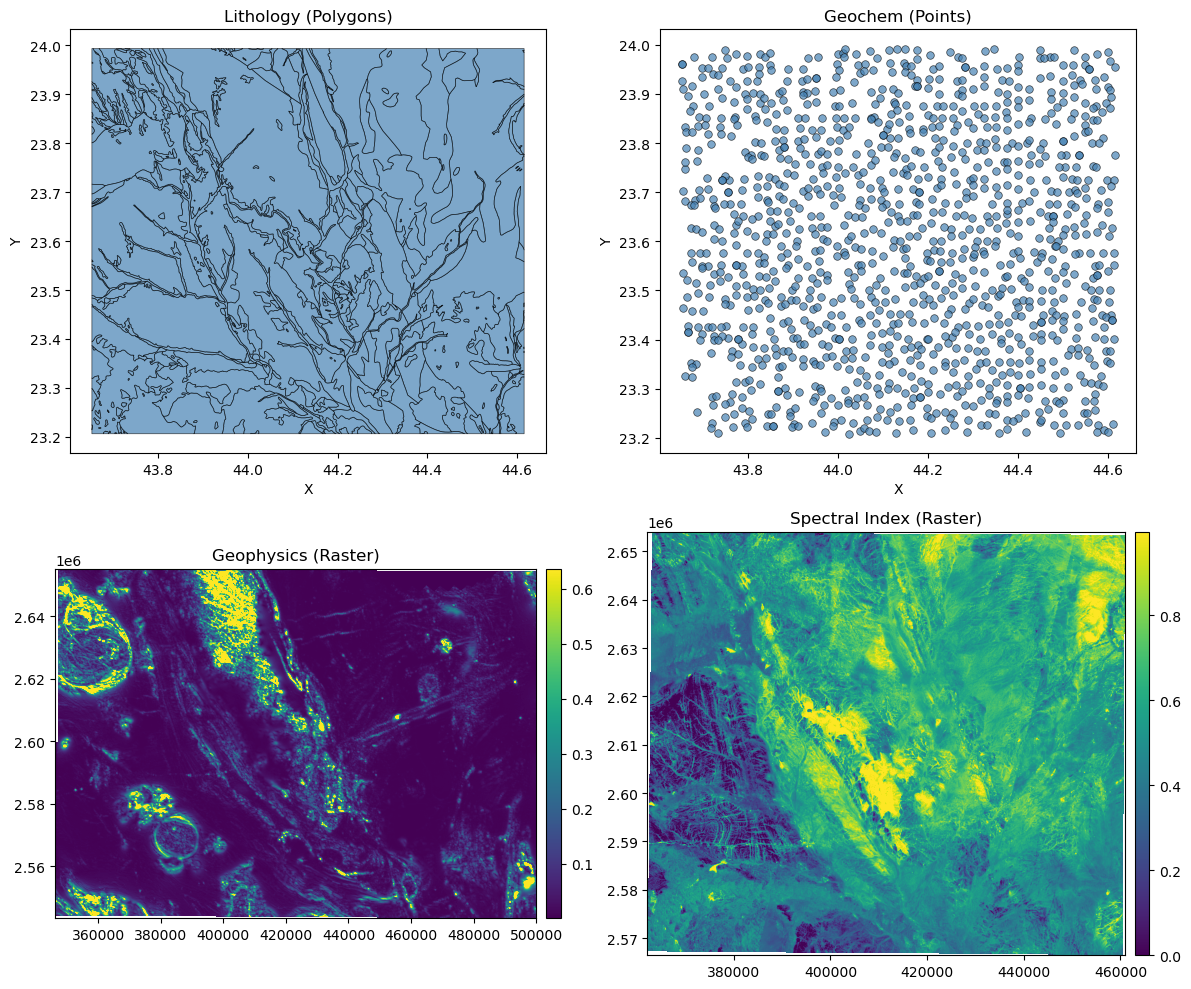

In [ ]:
# Data format examples: one of each type
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Lithology polygons
h.plot_vector(vector_gdf, ax=axes[0, 0], title='Lithology (Polygons)', categorical=True)

# Geochem points
h.plot_vector(geochem_gdf, ax=axes[0, 1], title='Geochem (Points)', markersize=30)

# Geophysics raster (if provided)
geophys_data = None
if DATA_CONFIG.get('geophysics_dir'):
    geo_dir = Path(DATA_CONFIG['geophysics_dir'])
    geo_tifs = sorted(geo_dir.glob('*.tif'))
    if geo_tifs:
        geophys_data, geophys_extent, _ = h.load_raster(geo_tifs[0])

if geophys_data is None:
    geophys_data = continuous_raster
    geophys_extent = raster_extent

h.plot_raster(geophys_data, ax=axes[1, 0], title='Geophysics (Raster)', extent=geophys_extent)

# Spectral index raster (if provided)
spectral_data = None
if DATA_CONFIG['spectral_indices_dir']:
    spec_dir = Path(DATA_CONFIG['spectral_indices_dir'])
    spec_tifs = sorted(spec_dir.glob('*.tif'))
    if spec_tifs:
        spectral_data, spectral_extent, _ = h.load_raster(spec_tifs[0])

if spectral_data is None:
    spectral_data = continuous_raster
    spectral_extent = raster_extent

h.plot_raster(spectral_data, ax=axes[1, 1], title='Spectral Index (Raster)', extent=spectral_extent)

plt.tight_layout()
plt.show()


## EDA, Transformations, and Scaling


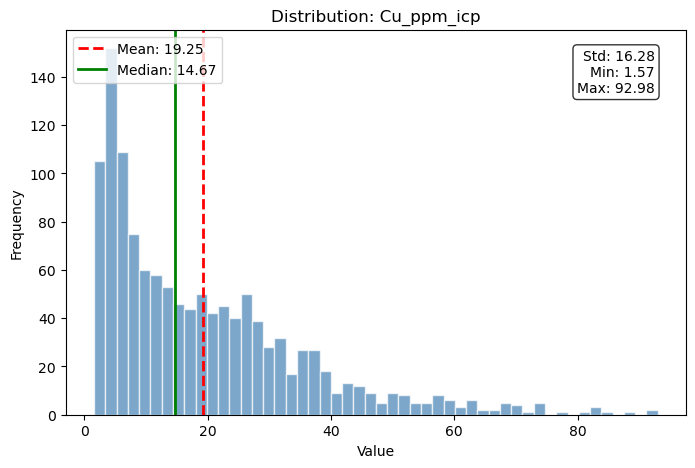

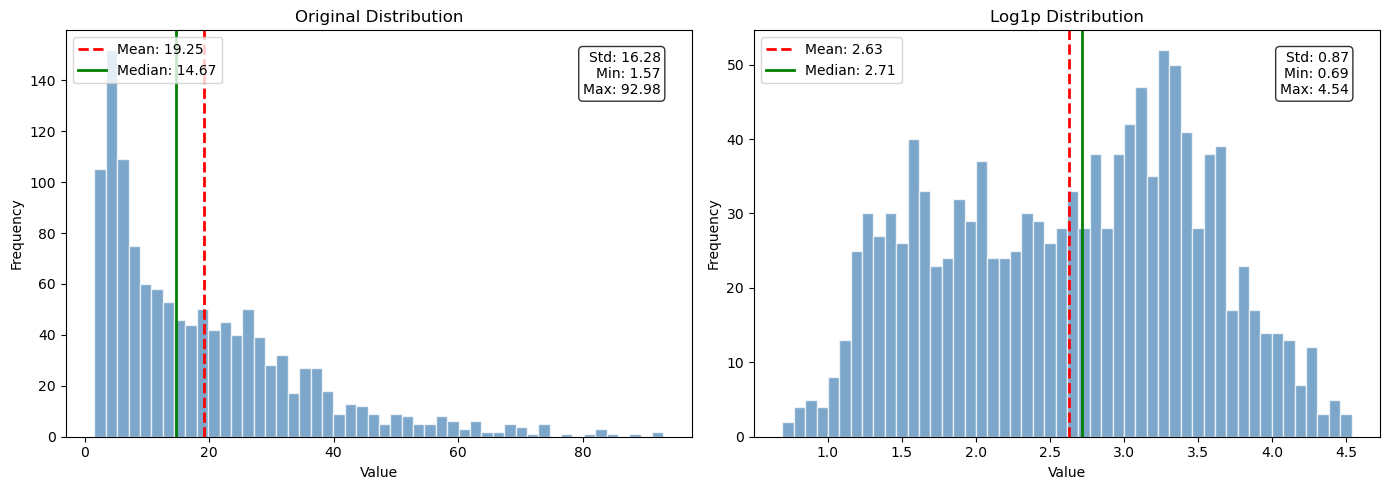

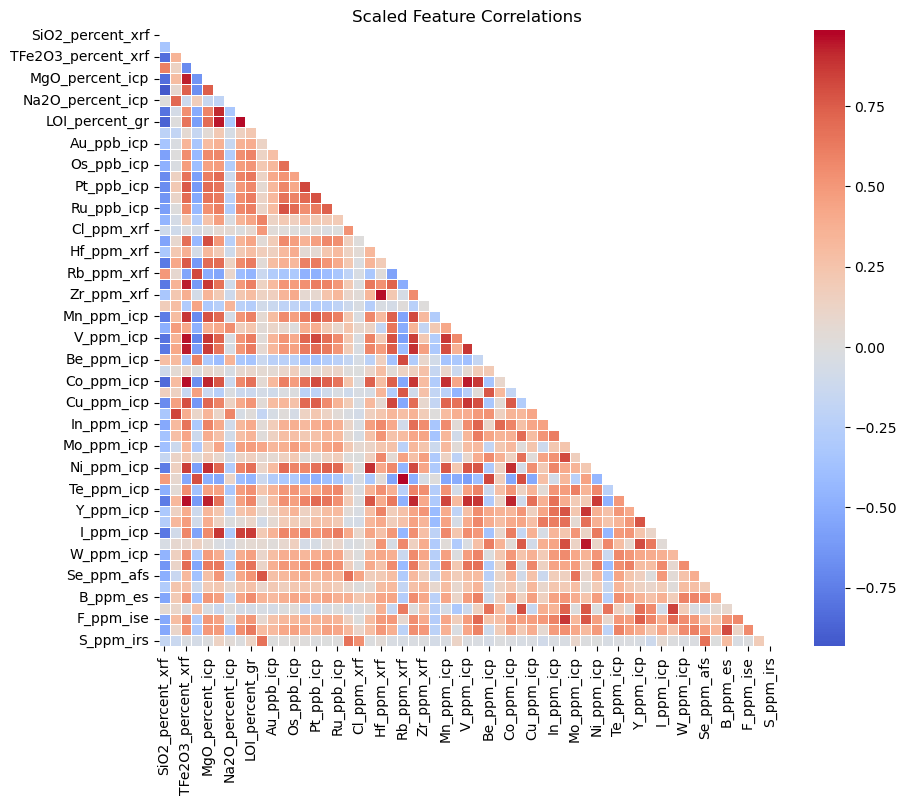

In [21]:
# Identify numeric feature columns
numeric_cols = geochem_gdf.select_dtypes(include=[np.number]).columns.tolist()
exclude_cols = {'X', 'Y', 'id', 'coord_x', 'coord_y', 'elevation_m'}
feature_cols = [c for c in numeric_cols if c not in exclude_cols]
if not feature_cols:
    raise ValueError('No numeric feature columns found in geochem data.')

# Prefer a Cu column for demonstrations
cu_candidates = [c for c in numeric_cols if 'cu' in c.lower()]
value_col = cu_candidates[0] if cu_candidates else feature_cols[0]
values = geochem_gdf[value_col].values

# Distribution and log transform
h.plot_distribution(values, title=f'Distribution: {value_col}')
plt.show()

log_values = np.log1p(values - np.nanmin(values) + 1)
h.plot_transformation_comparison(values, log_values, transform_name='Log1p')
plt.show()

# Scaling
scaler = StandardScaler()
scaled_features = scaler.fit_transform(geochem_gdf[feature_cols])
scaled_df = pd.DataFrame(scaled_features, columns=feature_cols)

h.plot_correlation_matrix(scaled_df, title='Scaled Feature Correlations', annot=False)
plt.show()


## Missing Data and Imputation


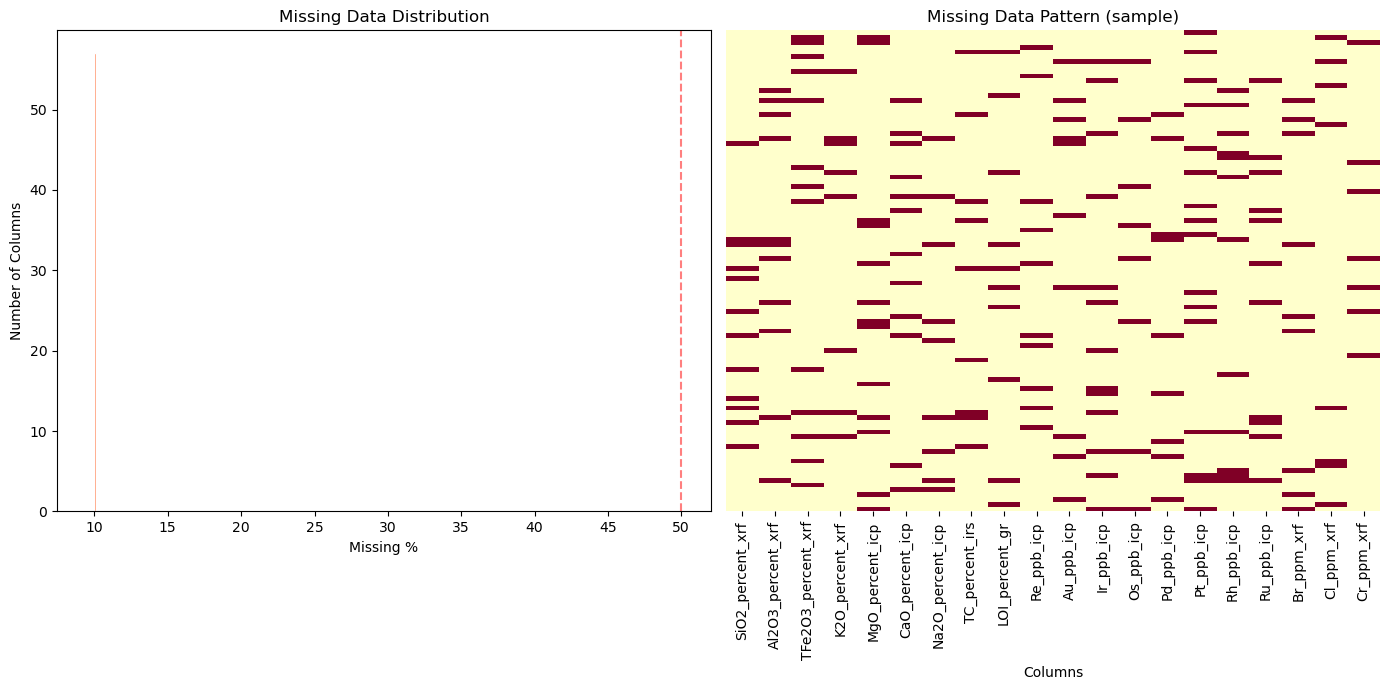

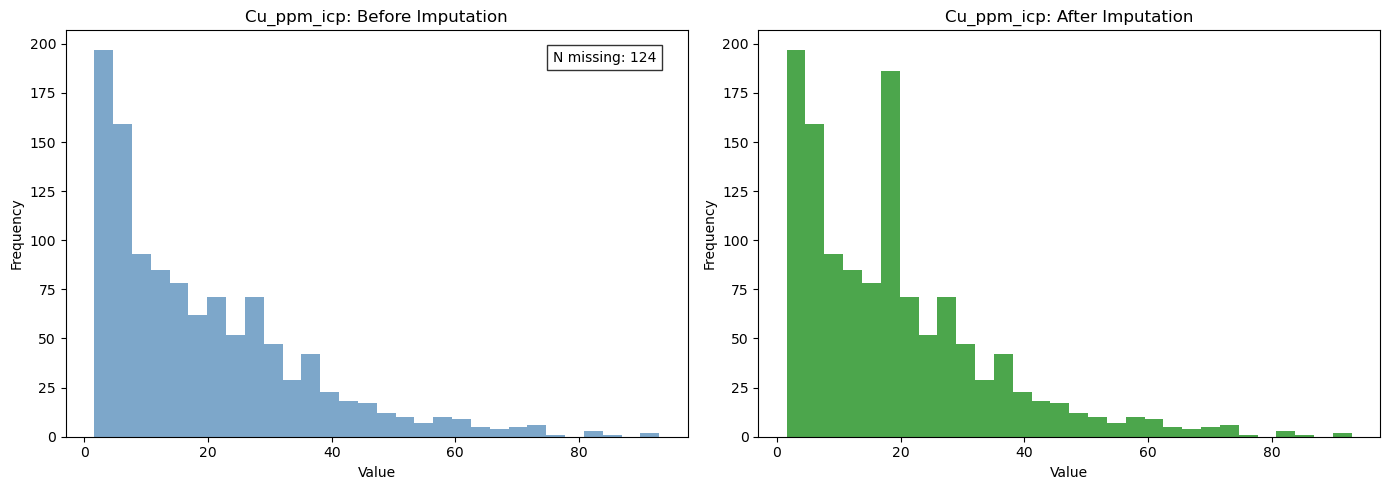

In [22]:
# Inject missing values for demonstration
geochem_missing = h.add_missing_data(geochem_gdf, missing_pct=0.1, columns=feature_cols)

h.plot_missing_data_pattern(geochem_missing[feature_cols], figsize=(14, 7))
plt.show()

# Mean imputation
imputer = SimpleImputer(strategy='mean')
imputed_values = imputer.fit_transform(geochem_missing[feature_cols])

h.plot_imputation_comparison(
    geochem_missing[value_col].values,
    imputed_values[:, feature_cols.index(value_col)],
    column_name=value_col
)
plt.show()


## Bias and Data Leakage (Spatial Autocorrelation)

Geologic data are often spatially autocorrelated, which inflates model performance when random train/test splits are used. Use spatially aware validation (e.g., block cross-validation or buffered splits) to reduce leakage.


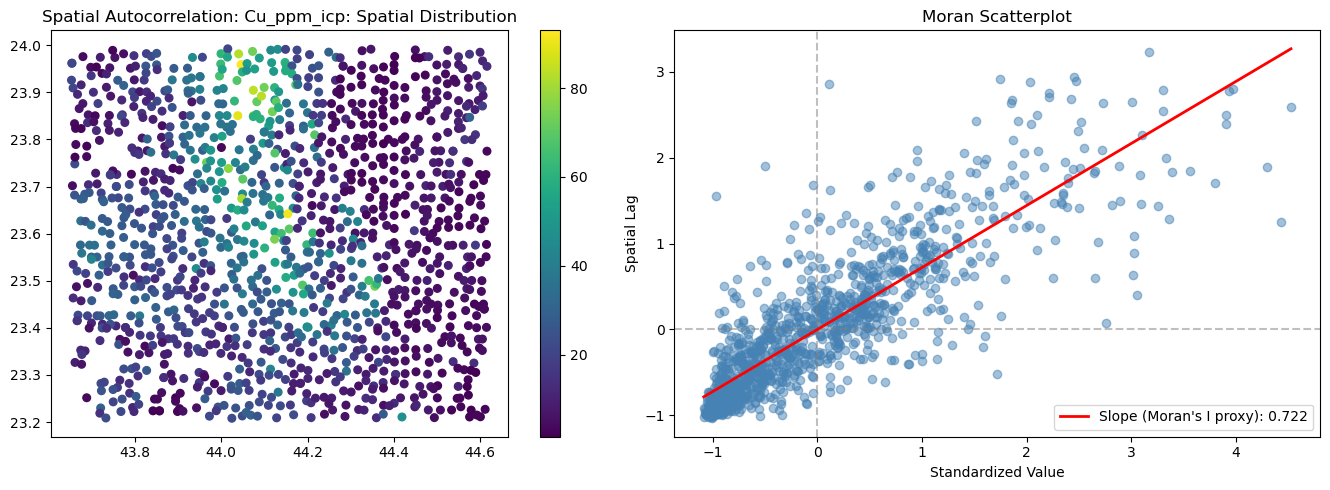

In [7]:
values = geochem_gdf[value_col].values
h.plot_spatial_autocorrelation(geochem_gdf, values, title=f'Spatial Autocorrelation: {value_col}')
plt.show()


## Analytical Methods


### Interpolation (IDW + Kriging)


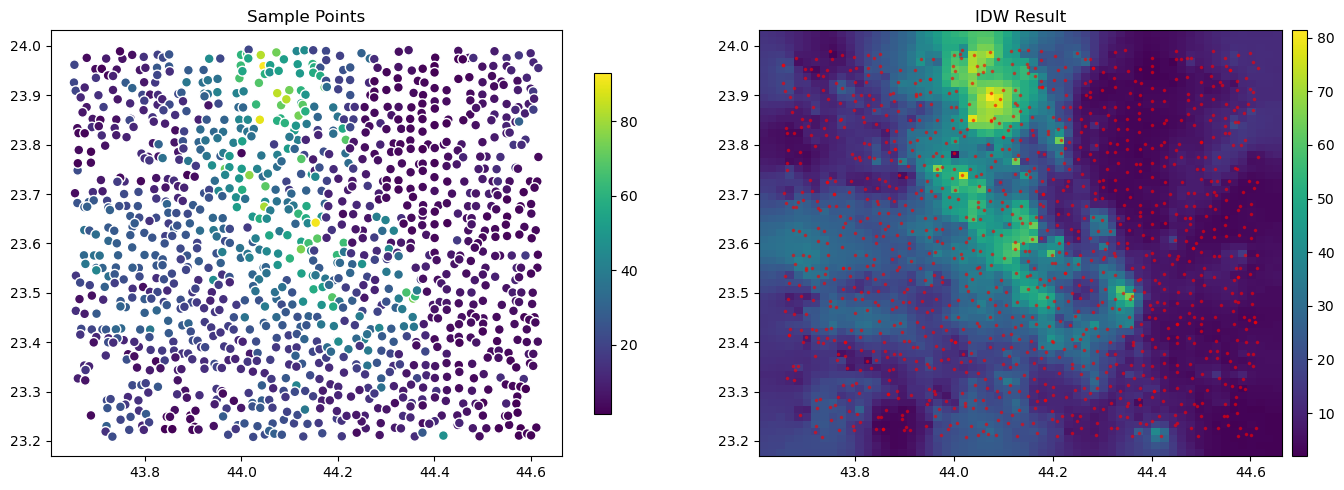

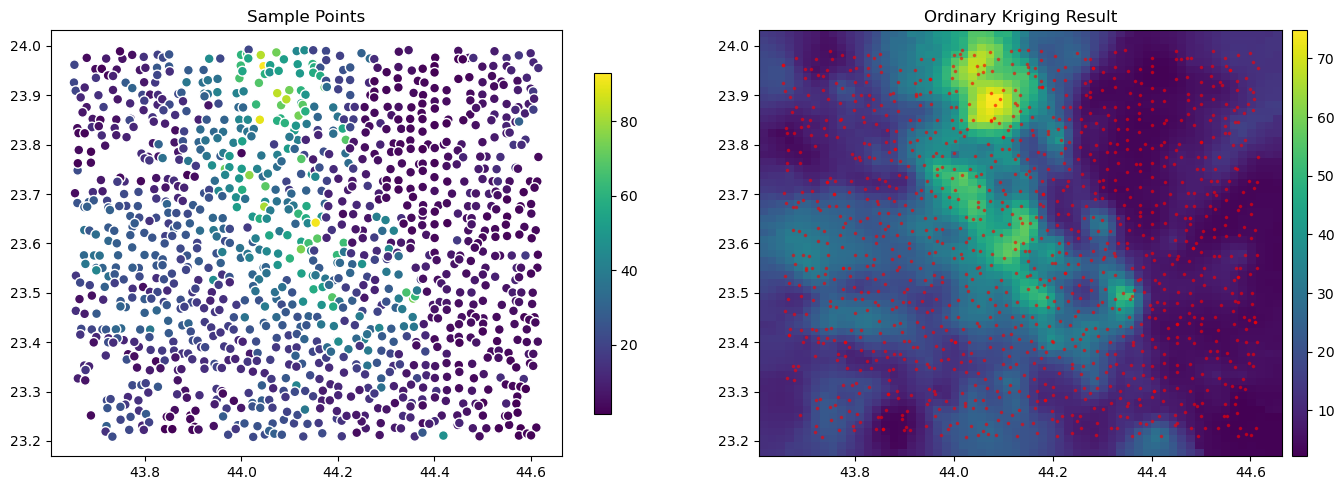

In [8]:
# Prepare sample points and grid
sample_coords = geochem_gdf[['X', 'Y']].values
sample_values = geochem_gdf[value_col].values

xmin, xmax = sample_coords[:, 0].min(), sample_coords[:, 0].max()
ymin, ymax = sample_coords[:, 1].min(), sample_coords[:, 1].max()

# Add padding to avoid edge effects
pad_x = (xmax - xmin) * 0.05
pad_y = (ymax - ymin) * 0.05
interp_extent = (xmin - pad_x, xmax + pad_x, ymin - pad_y, ymax + pad_y)

xmin, xmax, ymin, ymax = interp_extent
grid_resolution = 60
x_grid = np.linspace(xmin, xmax, grid_resolution)
y_grid = np.linspace(ymin, ymax, grid_resolution)
xx, yy = np.meshgrid(x_grid, y_grid)
grid_points = np.column_stack([xx.ravel(), yy.ravel()])

# IDW interpolation
idw_pred = h.idw_interpolation(sample_coords, sample_values, grid_points, power=2)
idw_grid = idw_pred.reshape(grid_resolution, grid_resolution)

h.plot_interpolation_results(sample_coords, sample_values, idw_grid, interp_extent, method_name='IDW')
plt.show()

# Fit variogram (no plot)
lags, semivar = h.compute_semivariogram(sample_coords, sample_values)
nugget, sill, range_param = h.fit_variogram(lags, semivar)

kriging_pred, kriging_var = h.ordinary_kriging(
    sample_coords, sample_values, grid_points, nugget, sill, range_param, n_neighbors=12
)

kriging_grid = kriging_pred.reshape(grid_resolution, grid_resolution)

h.plot_interpolation_results(sample_coords, sample_values, kriging_grid, interp_extent, method_name='Ordinary Kriging')
plt.show()


### PCA


Original dimensions: 57


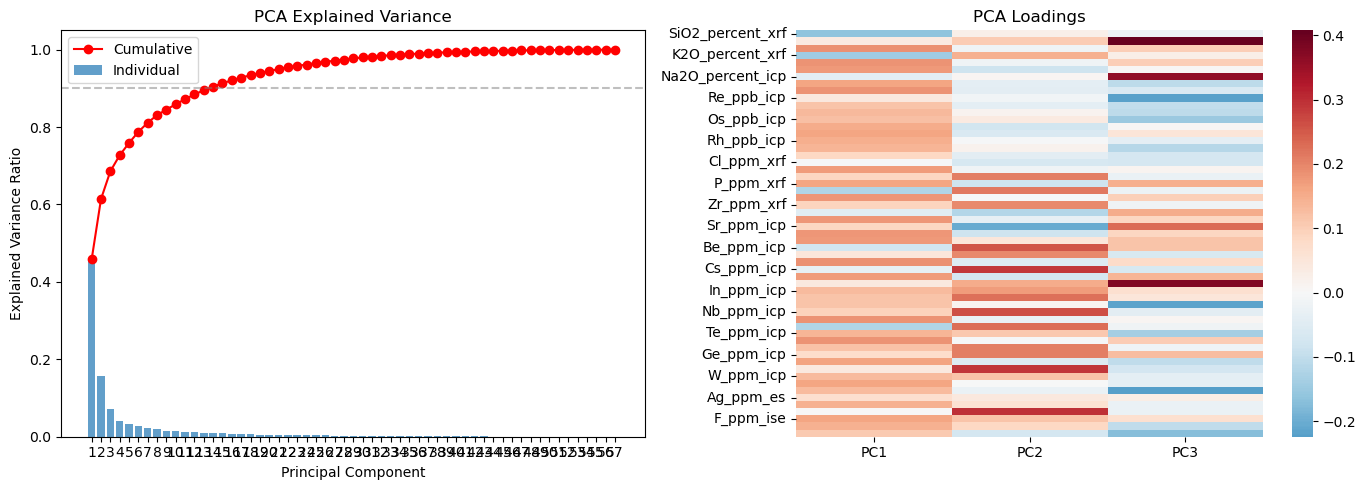

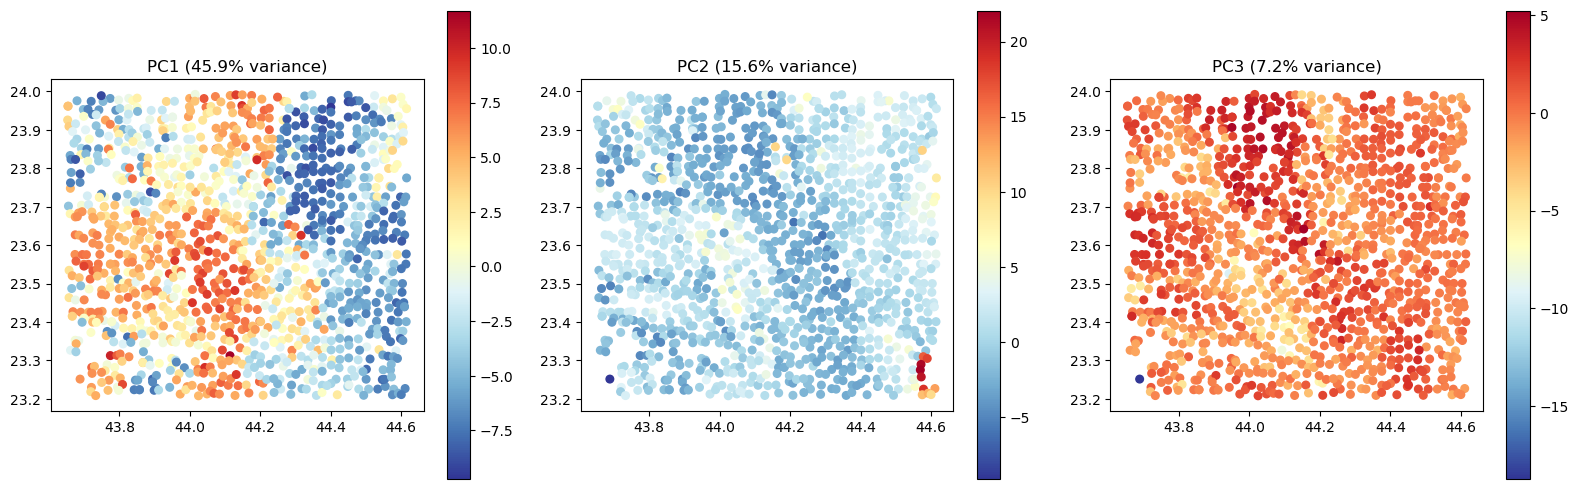

In [9]:
# Prepare data for PCA
pca_exclude = {'id', 'elevation_m'}
pca_cols = [c for c in feature_cols if c not in pca_exclude]

X_geochem = geochem_gdf[pca_cols].values

# Log transform (common for geochemical data)
X_log = np.log(X_geochem + 1)

# Standardize
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_log)

# Apply PCA
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

print(f"Original dimensions: {X_geochem.shape[1]}")

# Visualize PCA results
fig, axes = h.plot_pca_results(pca, pca_cols, figsize=(14, 5))
plt.show()


# Spatial visualization of principal components
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

for i, ax in enumerate(axes):
    gdf_temp = geochem_gdf.copy()
    gdf_temp[f'PC{i+1}'] = X_pca[:, i]
    gdf_temp.plot(column=f'PC{i+1}', ax=ax, legend=True, cmap='RdYlBu_r', markersize=30)
    ax.set_title(f'PC{i+1} ({pca.explained_variance_ratio_[i]*100:.1f}% variance)')

plt.tight_layout()
plt.show()


### K-means (Geochemical Populations)


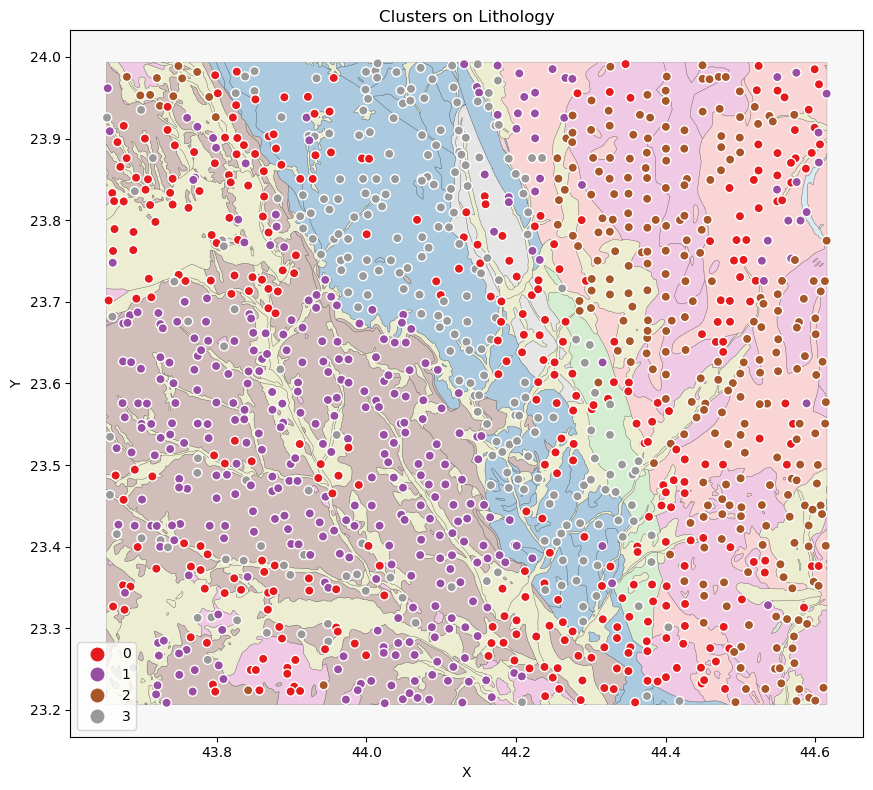

In [16]:
# Overlay clusters on lithology
fig, ax = plt.subplots(figsize=(10, 8))

lith_column = 'gross_lithology'
lith_column = 'geology_name'
lith_column = 'geological_period'
lith_column = 'tectonic_setting'


if lith_column in vector_gdf.columns:
    h.plot_vector(
        vector_gdf,
        column=lith_column,
        categorical=True,
        categorical_cmap='tab20',
        ax=ax,
        title='Clusters on Lithology',
        alpha=0.35,
        edgecolor='black',
        linewidth=0.3,
    )
else:
    vector_gdf.plot(ax=ax, facecolor='none', edgecolor='black', linewidth=0.4)
    ax.set_title('Clusters on Lithology')

# Ensure clustering exists
if 'cluster_labels' not in globals():
    optimal_k = 4
    kmeans_final = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
    cluster_labels = kmeans_final.fit_predict(X_scaled)

# Cluster points with high contrast
gdf_clustered = geochem_gdf.copy()
gdf_clustered['cluster'] = cluster_labels

gdf_clustered.plot(
    column='cluster',
    ax=ax,
    legend=True,
    categorical=True,
    cmap='Set1',
    markersize=45,
    edgecolor='white',
    linewidth=1.0,
)

ax.set_facecolor('#f7f7f7')
plt.tight_layout()
plt.show()


### Multivariate Anomaly Detection (Isolation Forest)

See full reference implementation in `anomaly_detection/`.


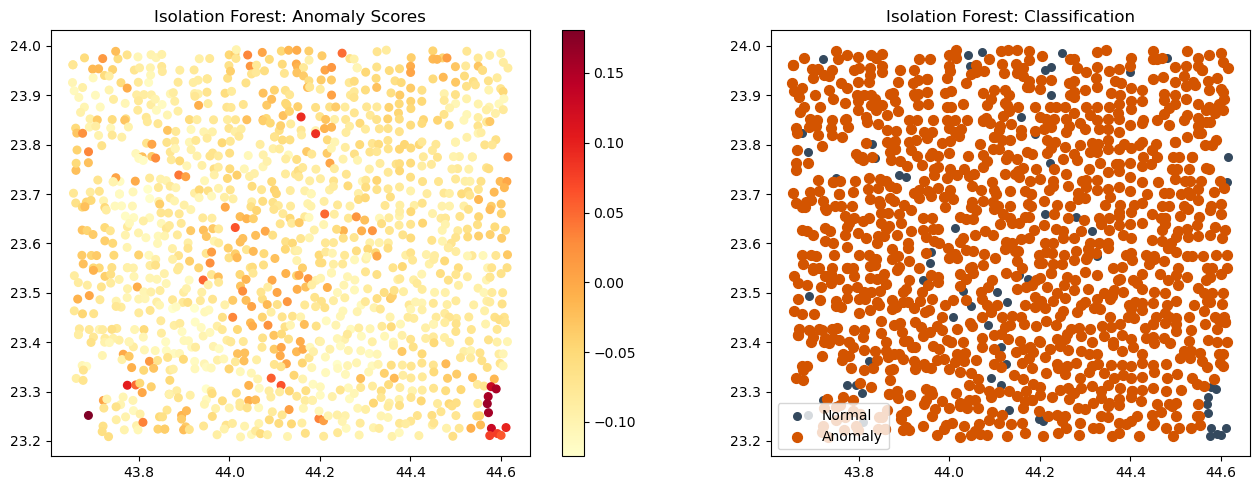

In [11]:
# Omit non-informative columns for anomaly detection
anom_exclude = {'id', 'coord_x', 'coord_y', 'elevation_m'}
anom_cols = [c for c in feature_cols if c not in anom_exclude]

# Use PCA-scaled features for anomaly detection
X_anom_scaled = X_scaled

iso = IsolationForest(n_estimators=200, contamination=0.05, random_state=42)
iso_labels = iso.fit_predict(X_anom_scaled)
scores = -iso.decision_function(X_anom_scaled)

h.plot_anomaly_scores(geochem_gdf, scores, binary_labels=iso_labels, title='Isolation Forest')
plt.show()


### Spectral Halo Classification

See full reference implementation in `MinersWork/spectral_unsupervised/spectral_unsupervised_class.ipynb`.


Use indices like clay/Al-OH, iron oxide (ferric), ferrous iron, silica, gossan, and laterite. Sentinel-2 does not provide a direct carbonate index, so these act as proxies.


Loaded 7 spectral indices


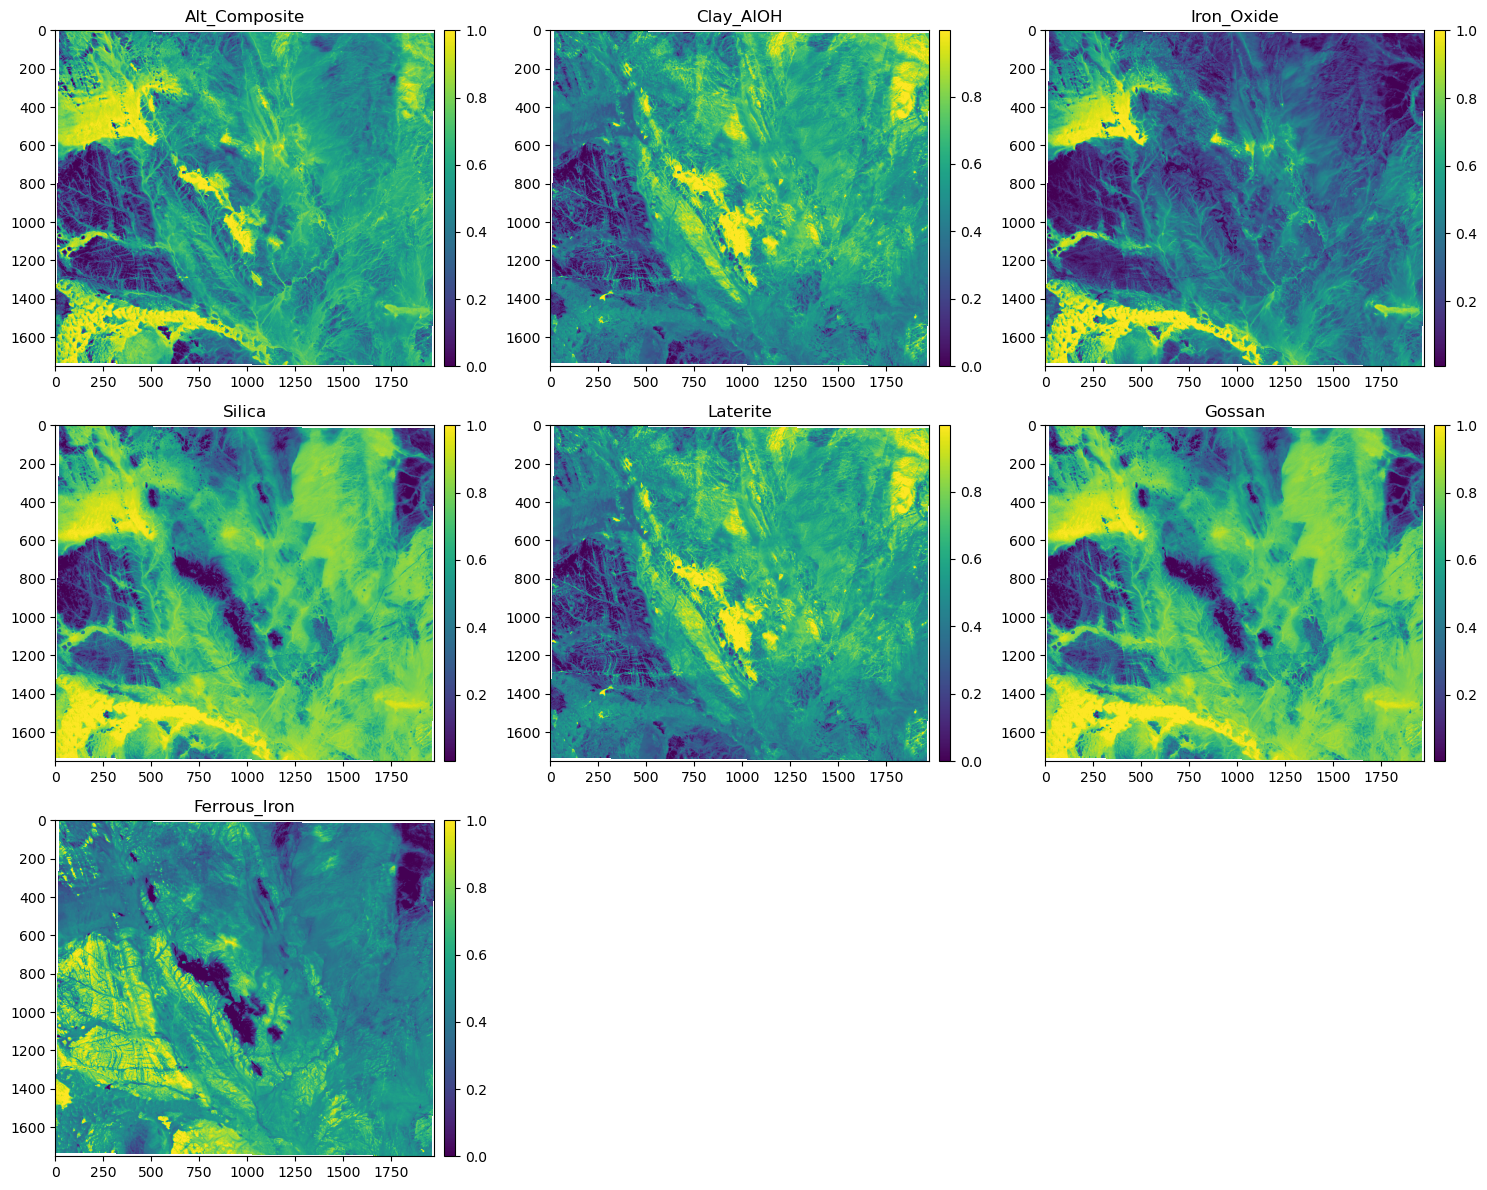

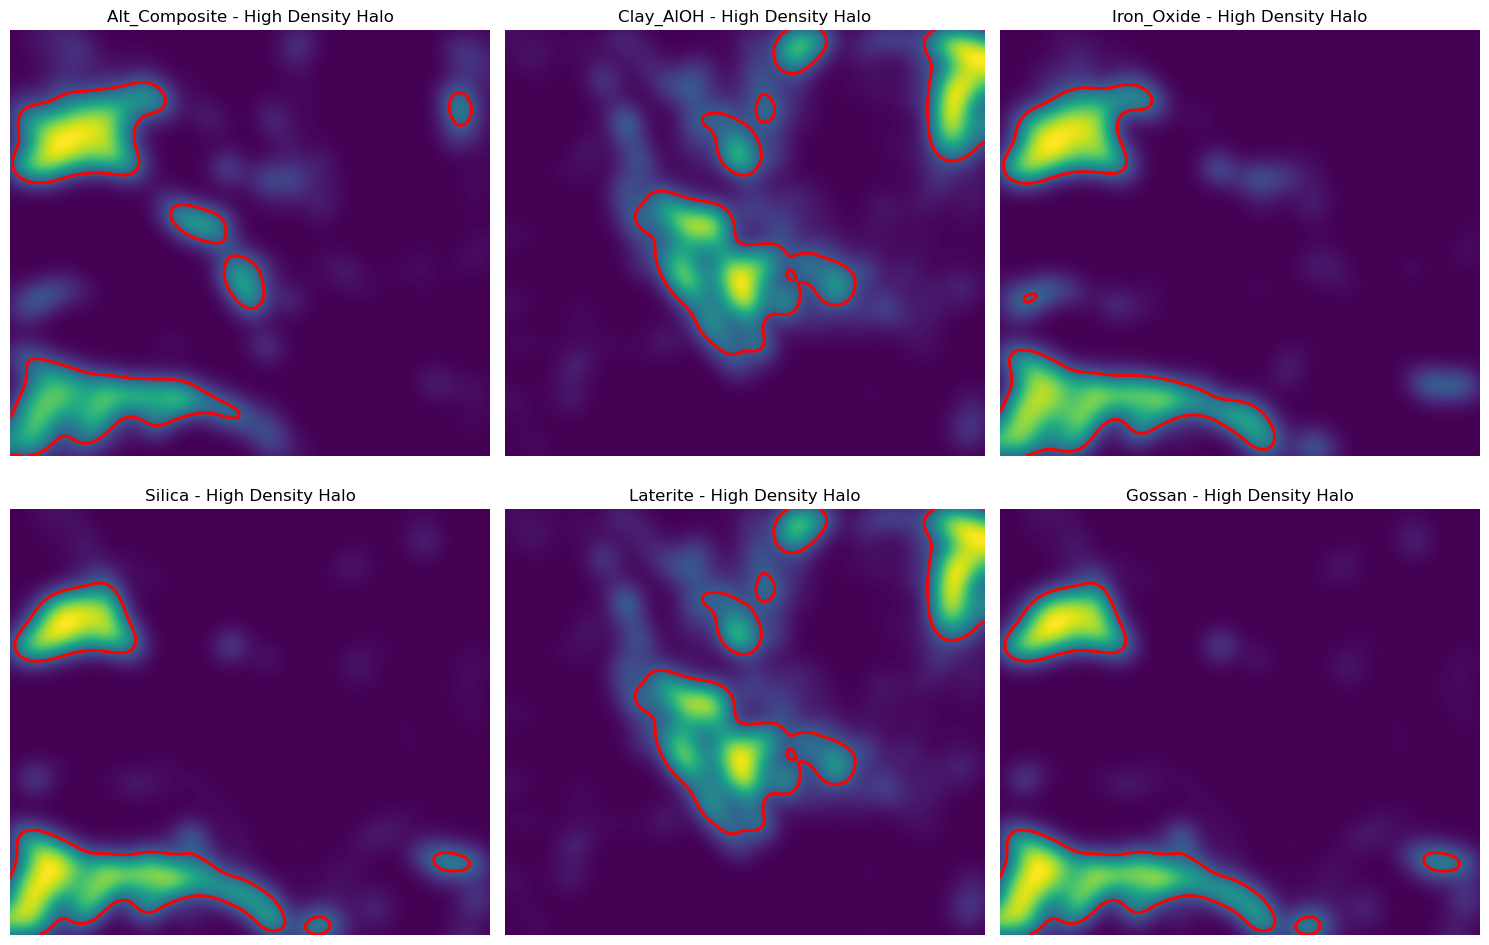

Alteration type classes:
0: Background
1: Advanced Argillic (95885 pixels, 2.8%)
2: Phyllic (280753 pixels, 8.1%)
3: Argillic (182799 pixels, 5.3%)
4: Propylitic (1426788 pixels, 41.2%)
5: Gossan (251723 pixels, 7.3%)
6: Laterite (502179 pixels, 14.5%)


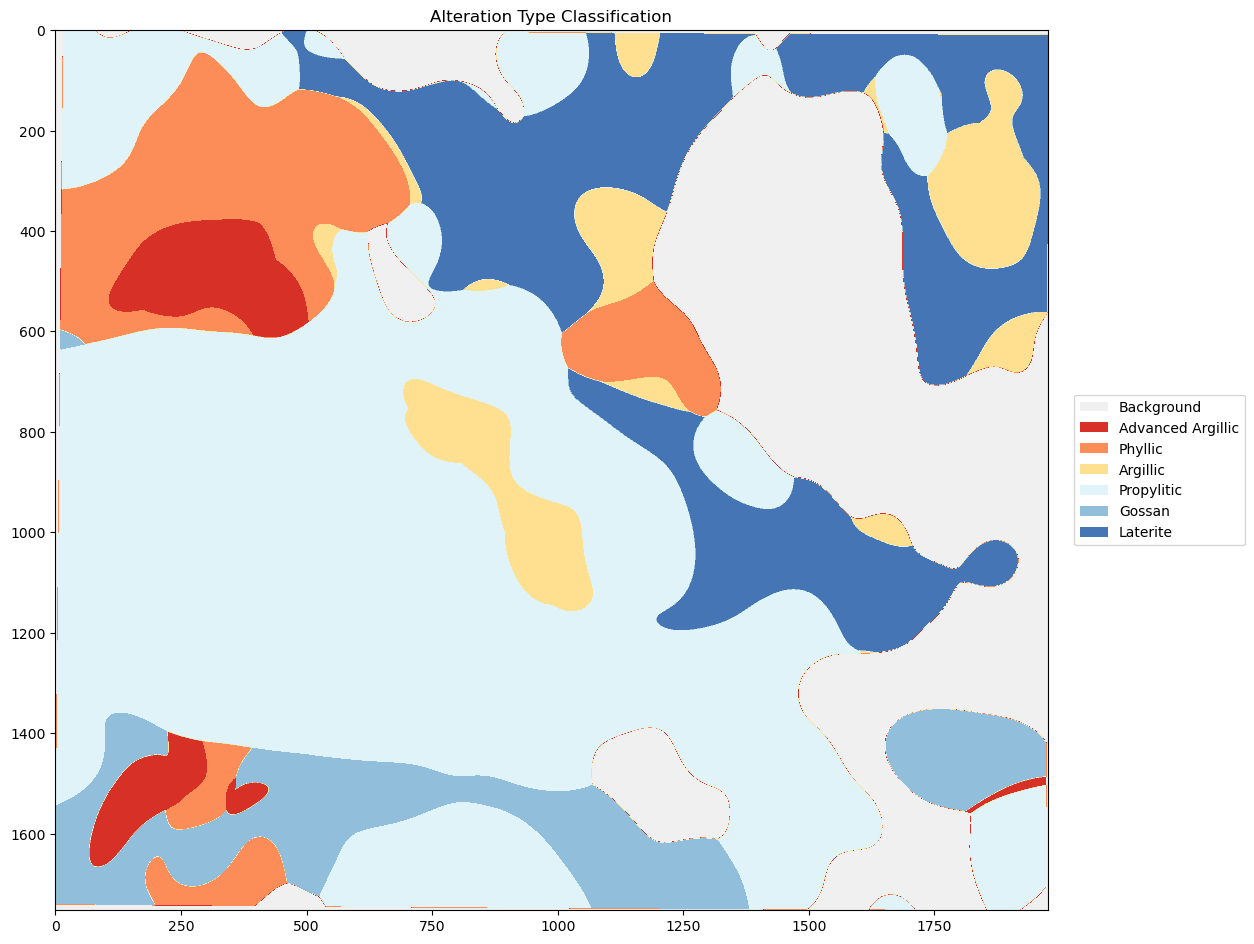


SPECTRAL HALO CLASSIFICATION:
-----------------------------
This unsupervised approach identifies alteration types based on:
1. Spectral index values (proxy for mineralogy)
2. Spatial density patterns (KDE)
3. Weighted combinations based on expected assemblages

Validation should include:
- Field verification of predicted alteration types
- Comparison with known mineralization
- Cross-validation with other datasets (geochemistry, geophysics)



In [12]:
# Generate or load spectral indices for demonstration
# In practice, these would be computed from multispectral imagery

np.random.seed(42)

spectral_indices = {}

if DATA_CONFIG['spectral_indices_dir']:
    dir_path = Path(DATA_CONFIG['spectral_indices_dir'])
    spectral_extent = None
    for tif_path in dir_path.glob('*.tif'):
        data, extent, _ = h.load_raster(tif_path)
        data = np.array(data, dtype=float)
        data[~np.isfinite(data)] = np.nan
        spectral_indices[tif_path.stem] = data
        if spectral_extent is None:
            spectral_extent = extent
    if spectral_extent is None:
        spectral_extent = raster_extent

if not spectral_indices:
    raster_shape = (100, 100)
    spectral_indices = {
        'Clay_AlOH': h.generate_spectral_index(raster_shape, n_anomalies=4),
        'Iron_Oxide': h.generate_spectral_index(raster_shape, n_anomalies=3),
        'Ferrous_Iron': h.generate_spectral_index(raster_shape, n_anomalies=2),
        'Silica': h.generate_spectral_index(raster_shape, n_anomalies=3),
        'Gossan': h.generate_spectral_index(raster_shape, n_anomalies=2),
        'Laterite': h.generate_spectral_index(raster_shape, n_anomalies=2),
    }

spectral_indices = h.map_spectral_indices(spectral_indices)

raster_shape = next(iter(spectral_indices.values())).shape
first_index = next(iter(spectral_indices.values()))
valid_mask = np.isfinite(first_index)
print(f"Loaded {len(spectral_indices)} spectral indices")

# Visualize spectral indices
n_indices = len(spectral_indices)
cols = 3
rows = int(np.ceil(n_indices / cols))
fig, axes = plt.subplots(rows, cols, figsize=(5 * cols, 4 * rows))
axes = np.atleast_1d(axes).ravel()

for ax, (name, data) in zip(axes, spectral_indices.items()):
    h.plot_raster(data, ax=ax, title=name, cmap='viridis', robust_stretch=True)

for ax in axes[len(spectral_indices):]:
    ax.axis('off')

plt.tight_layout()
plt.show()

# Apply halo detection for each index
kde_surfaces = {}
halo_masks = {}
for name, data in spectral_indices.items():
    kde, mask = h.compute_halo_detection(
        data,
        presence_quantile=0.9,
        sigma_px=50,
        clip_q=(0.01, 0.99),
        valid_mask=valid_mask,
    )
    kde_surfaces[name] = kde
    halo_masks[name] = mask

# Visualize halo detection results
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for ax, (name, kde) in zip(axes, kde_surfaces.items()):
    ax.imshow(kde, cmap='viridis', origin='upper')
    ax.contour(halo_masks[name], levels=[0.5], colors='red', linewidths=2)
    ax.set_title(f'{name} - High Density Halo')
    ax.axis('off')

for ax in axes[len(kde_surfaces):]:
    ax.axis('off')

plt.tight_layout()
plt.show()

# Alteration type classification using weighted combination
# Weights based on typical alteration assemblages
alteration_weights = {
    'Advanced Argillic': {'Clay_AlOH': 0.4, 'Silica': 0.25, 'Iron_Oxide': 0.15, 'Alt_Composite': 0.2},
    'Phyllic': {'Clay_AlOH': 0.4, 'Iron_Oxide': 0.25, 'Silica': 0.15, 'Alt_Composite': 0.2},
    'Argillic': {'Clay_AlOH': 0.4, 'Silica': 0.2, 'Laterite': 0.2, 'Alt_Composite': 0.2},
    'Propylitic': {'Ferrous_Iron': 0.4, 'Clay_AlOH': 0.2, 'Laterite': 0.2, 'Silica': 0.2},
    'Gossan': {'Iron_Oxide': 0.35, 'Gossan': 0.35, 'Silica': 0.15, 'Alt_Composite': 0.15},
    'Laterite': {'Laterite': 0.6, 'Iron_Oxide': 0.2, 'Clay_AlOH': 0.2},
}
# Normalize all KDE surfaces
kde_normalized = {name: h.normalize_kde(kde) for name, kde in kde_surfaces.items()}

# Compute weighted scores for each alteration type
alteration_scores = {}
valid_classes = []
for alt_type, weights in alteration_weights.items():
    score = np.zeros(raster_shape)
    used = 0
    for index_name, weight in weights.items():
        if index_name in kde_normalized:
            score += weight * kde_normalized[index_name]
            used += 1
    if used > 0:
        alteration_scores[alt_type] = h.normalize_kde(score)
        valid_classes.append(alt_type)

if not valid_classes:
    raise ValueError('No matching spectral indices found for alteration weights.')

# Classify based on highest score
all_scores = np.stack([alteration_scores[k] for k in valid_classes], axis=-1)
class_map = np.argmax(all_scores, axis=-1) + 1

# Mask low-confidence areas
max_scores = np.max(all_scores, axis=-1)
finite_mask = np.isfinite(max_scores)
if np.any(finite_mask):
    confidence_threshold = np.nanpercentile(max_scores[finite_mask], 20)
else:
    confidence_threshold = 0

class_map[max_scores < confidence_threshold] = 0
if "valid_mask" in locals():
    class_map[~valid_mask] = 0

print("Alteration type classes:")
print("0: Background")
for i, name in enumerate(valid_classes, 1):
    count = (class_map == i).sum()
    print(f"{i}: {name} ({count} pixels, {count / class_map.size * 100:.1f}%)")

# Visualize alteration classification
class_names = ['Background'] + valid_classes
fig, ax = h.plot_alteration_map(class_map, class_names=class_names, figsize=(12, 10))
plt.show()

print("""
SPECTRAL HALO CLASSIFICATION:
-----------------------------
This unsupervised approach identifies alteration types based on:
1. Spectral index values (proxy for mineralogy)
2. Spatial density patterns (KDE)
3. Weighted combinations based on expected assemblages

Validation should include:
- Field verification of predicted alteration types
- Comparison with known mineralization
- Cross-validation with other datasets (geochemistry, geophysics)
""")


### Supervised ML Prospectivity Mapping

See full reference implementation in `supervised_ML/`.


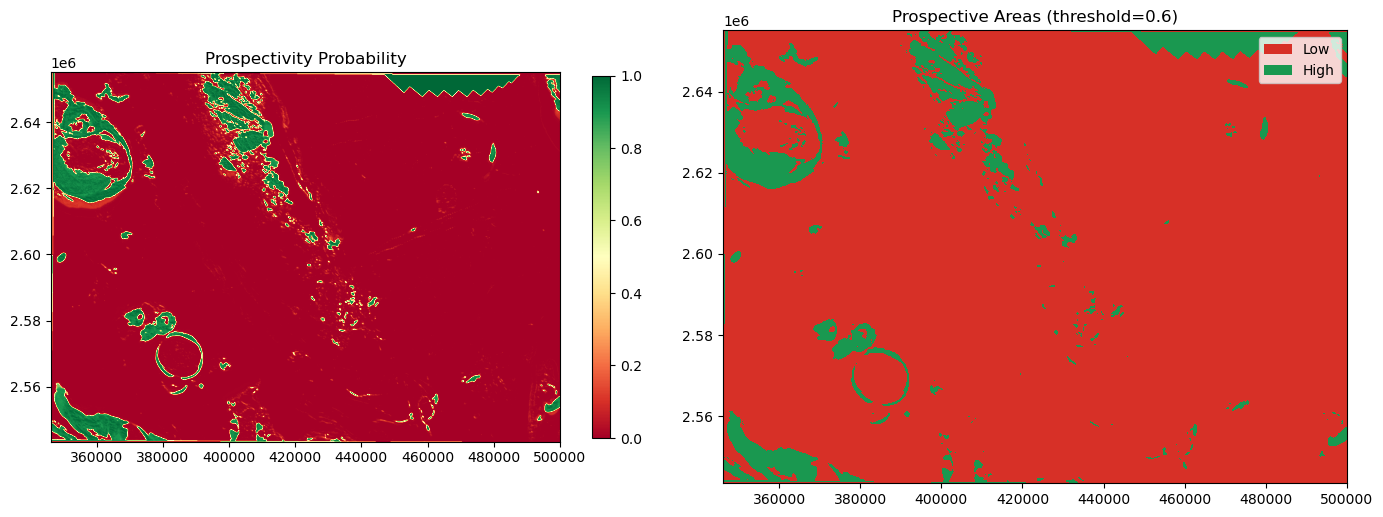

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       557
           1       1.00      1.00      1.00        43

    accuracy                           1.00       600
   macro avg       1.00      1.00      1.00       600
weighted avg       1.00      1.00      1.00       600



In [13]:
# Synthetic raster stack (or load from user paths)
feature_stack = []

if DATA_CONFIG['prospectivity_feature_rasters']:
    for path in DATA_CONFIG['prospectivity_feature_rasters']:
        data, extent, _ = h.load_raster(path)
        feature_stack.append(data)
    prospect_extent = extent

if DATA_CONFIG['geophysics_dir']:
    dir_path = Path(DATA_CONFIG['geophysics_dir'])
    for path in dir_path.glob('*.tif'):
        
        data, extent, _ = h.load_raster(path)
        feature_stack.append(data)
        if "prospect_extent" not in locals():
            prospect_extent = extent

if feature_stack:
    feature_stack = np.stack(feature_stack, axis=-1)
else:
    r1 = continuous_raster
    r2 = gaussian_filter(continuous_raster, sigma=4)
    r3 = np.flipud(continuous_raster)
    feature_stack = np.stack([r1, r2, r3], axis=-1)
    prospect_extent = raster_extent

rows, cols, n_features = feature_stack.shape

# Training data
if DATA_CONFIG['prospectivity_training_points_path']:
    train_gdf = h.load_vector(DATA_CONFIG['prospectivity_training_points_path'])
    label_candidates = [c for c in train_gdf.columns if c.lower() in ['label', 'target', 'prospectivity']]
    if not label_candidates:
        raise ValueError('Training points file must include a label column like label/target/prospectivity.')
    label_col = label_candidates[0]

    train_gdf = h.ensure_xy(train_gdf)
    xmin, xmax, ymin, ymax = prospect_extent

    col_idx = ((train_gdf['X'] - xmin) / (xmax - xmin) * (cols - 1)).astype(int)
    row_idx = ((ymax - train_gdf['Y']) / (ymax - ymin) * (rows - 1)).astype(int)
    valid = (col_idx >= 0) & (col_idx < cols) & (row_idx >= 0) & (row_idx < rows)

    X = feature_stack[row_idx[valid], col_idx[valid], :]
    y = train_gdf.loc[valid, label_col].values
else:
    # Synthetic labels from a high-value anomaly
    label_raster = (feature_stack[..., 0] > np.nanpercentile(feature_stack[..., 0], 92)).astype(int)

    n_samples = 2000
    rng = np.random.default_rng(42)
    row_idx = rng.integers(0, rows, n_samples)
    col_idx = rng.integers(0, cols, n_samples)

    X = feature_stack[row_idx, col_idx, :]
    y = label_raster[row_idx, col_idx]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

rf = RandomForestClassifier(n_estimators=200, random_state=42)
rf.fit(X_train, y_train)

# Predict prospectivity across the grid
flat_features = feature_stack.reshape(-1, n_features)
prob = rf.predict_proba(flat_features)[:, 1].reshape(rows, cols)

h.plot_prospectivity_map(prob, extent=prospect_extent, threshold=0.6)
plt.show()

# Evaluate
from sklearn.metrics import classification_report
print(classification_report(y_test, rf.predict(X_test)))
